# ACM30130 Assignment 3

**Due 5PM Friday 1 November 2024**

In this assignment you will study the evolution of a nonlinear oscillator using the finite difference approximation and an iterative method. In particular, we want to solve the differential equation
$$
\frac{d^2 x}{dt^2} - \mu (1-x^2)\frac{dx}{dt}+x=0
$$
as an *initial value problem* by specifying the two initial conditions
$$
x(0) = 1, \qquad \frac{dx}{dt}(0) = 1 .
$$

<!-- We will make use of a high-performance computing machine using Linux, the command line and ssh, to tackle the computationally-intense parts of the problem. -->

**1.** Write the above equation in the form $\mathcal{L}[x] = f(t,x)$ where $\mathcal{L}$ is a linear operator (so the left hand side is linear in $x$ and its derivatives), and $f(t, x)$ contains all the other (nonlinear) terms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, linalg
import time

In [2]:
def L(t, x, d2x_dt2, dx_dt, mu): 
    return d2x_dt2 -mu*dx_dt + x

def f(t, x, dx_dt, mu):
    return - mu* x**2 * dx_dt

**2.** Write a function that takes $N$ as the input and returns a vector containing the discrete, equally-spaced values $\{t_i\ |\ i=0,1,...,N\}$, where $t_0=0$ and $t_N=10$

In [3]:
def time_scale(N):
    return np.linspace(0, 10, N+1)

**3.** Create a matrix $A$ that represents the linear operator $\mathcal{L}$, leaving the *top two rows* blank for our initial conditions. The matrix will be used to operate on a vector $\mathbf{x}$ with entries $\{x_i\equiv x(t_i)\ |\ i=0,1,...,N\}$.

It will be useful to make this as a function that takes $\mu$ and $N$ as inputs and returns the matrix.

In [4]:
def SecondDeriv(N, h):
    A = sparse.diags([1,-2,1], [-2,-1, 0], shape=(N+1, N+1)).toarray()/(h**2)
    A[0,:]  = A[1,:]= 0
    return A

def FirstDeriv(N, h):
    A = sparse.diags_array([-1,1], offsets=[-2,0], shape=(N+1,N+1)).toarray()/(2*h)
    A[0,:]  = A[1,:] = 0
    return A

def ZeroDeriv(N):
    A = sparse.diags_array([1], offsets=[-1], shape=(N+1,N+1)).toarray()
    A[0,:]  = A[1,:] = 0
    return A

In [5]:
def LHS(mu, N, h):
    A = SecondDeriv(N, h) - mu* FirstDeriv(N, h) + ZeroDeriv(N)
    return A

**4.** Derive the second-order approximation for the initial condition $x'(0)$ that can be expressed in terms of the values $x_0$, $x_1$ and $x_2$. 
(If you write this out by hand, please submit this working as a scan on Brightspace)

Write a function that returns a matrix whose top two rows represent the two initial conditions $x(0)$ and $x'(0)$.

In [6]:
def IC(N, h):
    A = np.zeros((N+1, N+1))
    A[0, 0] = -3 / (2 * h)
    A[0, 1] = 4 / (2 * h)
    A[0, 2] = -1 / (2 * h)

    A[1, 0] = 1
    return A

**5.** Create a function that takes the parameter $\mu$ and a vector $\mathbf{x}$ as input and returns the nonlinear right side of the equation. Use a second-order finite difference approximation to estimate any derivatives.
Note that because we have put two rows of boundary conditions at the top of our matrix problem, the remaining elements of the right vector will be offset as
$$
f_{i+1}=f(t_i, x(t_i))
$$

In [7]:
def ModifiedFirstDeriv(N, h):
    A = sparse.diags_array([-1,1], offsets=[-1,1], shape=(N+1,N+1)).toarray()/(2*h)
    return A

In [8]:
def RHS(mu, x ,h): 
    N = len(x) - 1 
    first_deriv = ModifiedFirstDeriv(N, h)@ x 
    nonlinear_term = mu * (1 - x**2) * first_deriv 
    f = np.zeros(x.size) 
    f[2:] = nonlinear_term[2:]
    f[0] = f[1] = 1 
    return f

**6.** Write a function to return the Jacobian matrix
$$
J_{ij}=\frac{\partial f_i}{\partial x_j}
$$
for this right vector $\mathbf{f}$. The function should take $\mu$ and $\mathbf{x}$ as inputs (and may also take $N$ as an input, although this is not necessary if you think about it)

In [9]:
def Jacobian(mu, x, h):
    N = len(x) - 1
    first_deriv_matrix = ModifiedFirstDeriv(N, h)
    first_deriv_x = first_deriv_matrix @ x

    J = np.zeros((x.size, x.size))
    
    for i in range(2, N + 1):
        for j in range(2, N + 1):
            if i == j:
                J[i, j] = -2 * mu * x[i] * first_deriv_x[i] + mu * (1 - x[i]**2) * first_deriv_matrix[i, j]
            else:
                J[i, j] = mu * (1 - x[i]**2) * first_deriv_matrix[i, j]
    
    return J

**7.** Now put this all together. Write a function that performs a Newton iteration to find the solution $\mathbf{x}$ that satisfies our initial value problem. Use $10^{-10}$ as the tolerance for the $L^2$ norm of the residual, and use $x=\cos(t)+\sin(t)$ as the initial guess. The function should take $\mu$ and $N$ as inputs and return the number of iterations, the vector for $t$ and the solution vector for $x$.

Test this function for $\mu=1$ and $N=256$. Plot the solution $x(t)$.

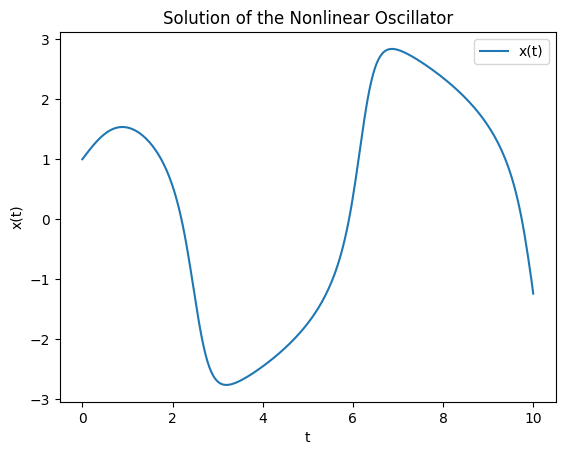

Number of iterations: 18
Norm: 4.6994214921508576e-12


In [10]:
def Solver(mu, N, tol=10e-10):
    t = time_scale(N)
    h = time_scale(N)[1]

    A = LHS(mu, N, h)+IC(N,h)

    x = np.cos(t)+np.sin(t)

    iterations = 0

    while True:
        J = Jacobian(mu, x, h)
        residual = A @ x - RHS(mu, x, h)
        norm_residual = linalg.norm(residual)
        if norm_residual <= tol:
            break
        x = x - linalg.solve(A - J, residual)
        iterations += 1

    return iterations, t, x, norm_residual

mu = 1
N = 256
iterations, t, x, norm = Solver(mu, N)

# Plot the solution x(t)
plt.plot(t, x, label='x(t)')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Solution of the Nonlinear Oscillator')
plt.legend()
plt.show()

print(f'Number of iterations: {iterations}')
print(f'Norm: {norm}')


**8.** Run your function for $N=\{64, 128, 256, 512, 1024, 2048\}$, recording the final value $x(t_N)=x(10)$ in each case. Use the Python function `time.time()` to measure the execution time of each run.

In [11]:
N_values = [64, 128, 256, 512, 1024, 2048]
results = []

for N in N_values:
    start_time = time.time()
    iterations, t, x, norm_residual = Solver(mu=1.0, N=N)
    end_time = time.time()
    execution_time = end_time - start_time
    results.append((N, x[-1], execution_time))

for N, x_final, exec_time in results:
    print(f'N = {N}, x(10) = {x_final}, Execution Time = {exec_time:.6f} seconds')


N = 64, x(10) = -1.8235175921455302, Execution Time = 0.083422 seconds
N = 128, x(10) = -24.25792412826168, Execution Time = 0.141708 seconds
N = 256, x(10) = -1.2374877515187173, Execution Time = 0.663693 seconds
N = 512, x(10) = -1.2346880857333609, Execution Time = 2.836527 seconds
N = 1024, x(10) = -1.2433637934217503, Execution Time = 11.428142 seconds
N = 2048, x(10) = -1.25020356232663, Execution Time = 35.231154 seconds


Outlier at N=128 iterating one time too many time resulting in sharp drop off, tolerance could be adjusted based on this. Likely due to central difference not applying to all last x terms not being applied to all x values. We could therofore increase the len of our x values and ignore the last values produced.

**9.** Using the two highest resolution cases, compute the Richardson extrapolation of $x(10)$

In [12]:
x_1024 = results[-2][1] 
x_2048 = results[-1][1]
p = 2

x_extrapolated = x_2048 + (x_2048 - x_1024) / ((2048 / 1024)**p - 1)

print(f"Richardson Extrapolated x(10): {x_extrapolated}")

Richardson Extrapolated x(10): -1.2524834852949234


**10.** Compute the relative error between the numerical calculations and the Richardson extrapolation and plot this against $N$. Carefully consider how you scale the axes. Are the results consistent with our solution method?

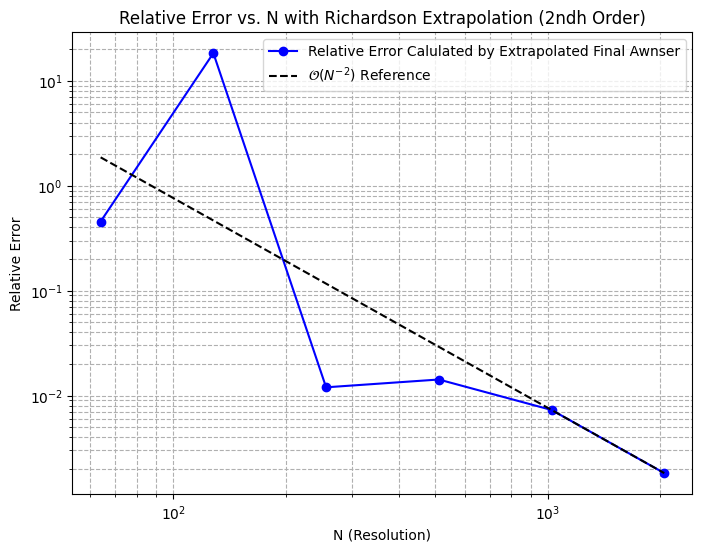

In [13]:
x_values = {
    64: results[0][1],    
    128: results[1][1],   
    256: results[2][1],   
    512: results[3][1],   
    1024: results[4][1], 
    2048: results[5][1] 
}

relative_errors = {}
for N, x_N in x_values.items():
    relative_errors[N] = abs(x_N - x_extrapolated) / abs(x_extrapolated)

plt.figure(figsize=(8, 6))
plt.loglog(list(relative_errors.keys()), list(relative_errors.values()), marker='o', linestyle='-', color='b', label='Relative Error Calulated by Extrapolated Final Awnser')

N_ref = np.array(list(relative_errors.keys()))
error_ref = relative_errors[N_ref[-1]] * (N_ref[-1] / N_ref)**2 
plt.loglog(N_ref, error_ref, 'k--', label=r"$\mathcal{O}(N^{-2})$ Reference")


plt.xlabel('N (Resolution)')
plt.ylabel('Relative Error')
plt.title('Relative Error vs. N with Richardson Extrapolation (2ndh Order)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()



Logarithmic Plot: Using loglog allows us to observe the convergence rate. The slope of the plot on this log-log scale should approach −2 (indicating 𝑂($N^{-2}$) error decay).
As N increases, the relative error should decrease, which indicates convergence towards the extrapolated value. This behavior confirms the consistency of our solution method with a second-order accurate scheme.

**11.** Now repeat all the same steps for a fourth-order approximation.
You will need to use the following approximations:
$$
\begin{align}
x''(t_i) &\approx \frac{-x_{i-2} + 16 x_{i-1} - 30 x_i + 16 x_{i+1} - x_{i+2}}{12h^2} \\ 
x'(t_i) &\approx \frac{x_{i-2} - 8 x_{i-1} + 8 x_{i+1} - x_{i+2}}{12h}
\end{align}
$$
You will only be able to apply these approximations for $2\leq i\leq N-2$, so you also have to apply off-centre derivatives at $t_1$ and $t_{N-1}$:
$$
\begin{align}
x''(t_1) &\approx \frac{11 x_0 - 20 x_1 + 6 x_2 + 4 x_3 - x_4}{12h^2}, \\
x''(t_{N-1}) &\approx \frac{- x_{N-4} + 4 x_{N-3} + 6 x_{N-2} - 20 x_{N-1} + 11 x_{N}}{12h^2},\\
x'(t_1) &\approx \frac{- 3 x_0 - 10 x_1 + 18 x_2 - 6 x_3 + x_4}{12h}, \\
x'(t_{N-1}) &\approx \frac{- x_{N-4} + 6 x_{N-3} - 18 x_{N-2} + 10 x_{N-1} + 3 x_{N}}{12h} .
\end{align}
$$
You will also need a fourth-order derivative for the boundary condition $x'(0)$, which you may take as
$$
x'(0)\approx \frac{-25 x_0 + 48 x_1 - 36 x_2 + 16 x_3 - 3 x_4}{12h}
$$

In [14]:
def SecondDeriv1(N, h):
    A = sparse.diags([-1, 16, -30, 16, -1], [-3, -2, -1, 0, 1], shape=(N+1, N+1)).toarray()/(12*h**2)
    A[2, 0:5] = np.array([11, -20, 6, 4, -1]) / (12 * h**2)
    A[N, -10:-5] = np.array([-1, 4, 6, -20, 11]) / (12 * h**2)
    A[0,:]  = A[1,:]= 0
    return A

def FirstDeriv1(N, h):
    A = sparse.diags_array([1, -8, 8, -1], offsets=[-3, -2, 0, -1], shape=(N+1,N+1)).toarray()/(12*h)
    A[2, 0:5] = np.array([-3, -10, 18, 6, 1]) / (12 * h)
    A[N, -10:-5] = np.array([-1, 6, -18, 10, 3]) / (12 * h)
    A[0,:]  = A[1,:] = 0
    return A

def IC1(N, h):
    A = np.zeros((N+1, N+1))
    A[0, 0:5] = [-25, 48, -36, 16, -3] / (12 * h)
    A[1, 0] = 1
    return A

def LHS1(mu, N, h):
    A = SecondDeriv(N, h) - mu * FirstDeriv(N, h) + ZeroDeriv(N)
    return A


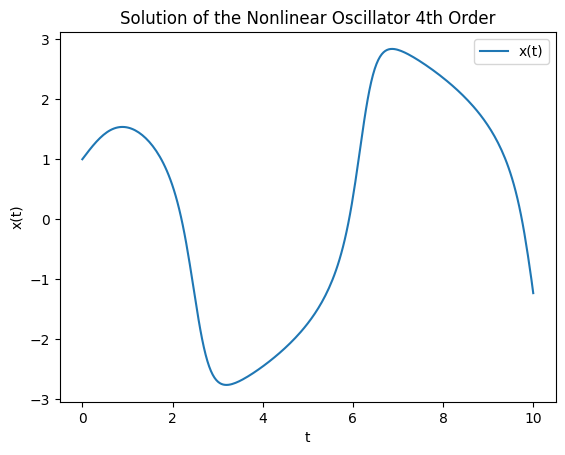

Number of iterations: 18
Norm: 4.459951677399278e-12


In [15]:
def Solver1(mu, N, tol=10e-10):
    t = time_scale(N)
    h = time_scale(N)[1]

    A = LHS1(mu, N, h)+IC1(N,h)

    x = np.cos(t)+np.sin(t)

    iterations = 0

    while True:
        J = Jacobian(mu, x, h)
        residual = A @ x - RHS(mu, x, h)
        norm_residual = linalg.norm(residual)
        if norm_residual <= tol:
            break
        x = x - linalg.solve(A - J, residual)
        iterations += 1

    return iterations, t, x, norm_residual

mu = 1
N = 256
iterations, t, x, norm = Solver1(mu, N)

# Plot the solution x(t)
plt.plot(t, x, label='x(t)')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Solution of the Nonlinear Oscillator 4th Order')
plt.legend()
plt.show()

print(f'Number of iterations: {iterations}')
print(f'Norm: {norm}')

In [16]:
N_values = [64, 128, 256, 512, 1024, 2048]
results = []

for N in N_values:
    start_time = time.time()
    iterations, t, x, norm_residual = Solver1(mu=1.0, N=N)
    end_time = time.time()
    execution_time = end_time - start_time
    results.append((N, x[-1], execution_time))

for N, x_final, exec_time in results:
    print(f'N = {N}, x(10) = {x_final}, Execution Time = {exec_time:.6f} seconds')


N = 64, x(10) = -11.328711057432635, Execution Time = 0.053315 seconds
N = 128, x(10) = -1.2887334214983, Execution Time = 0.137723 seconds
N = 256, x(10) = -1.2296522314844593, Execution Time = 0.586113 seconds
N = 512, x(10) = -1.2328865464922303, Execution Time = 2.817988 seconds
N = 1024, x(10) = -1.2429336729034544, Execution Time = 11.608800 seconds
N = 2048, x(10) = -1.2500986054508416, Execution Time = 35.601142 seconds


Outlier at N=64 iterating one time too many time resulting in sharp drop off, tolerance could be adjusted based on this. Likely due to central difference not applying to all last x terms not being applied to all x values. We could therofore increase the len of our x values and ignore the last values produced.

In [17]:
x_1024 = results[-2][1] 
x_2048 = results[-1][1]
p = 2

x_extrapolated = x_2048 + (x_2048 - x_1024) / ((2048 / 1024)**p - 1)

print(f"Richardson Extrapolated x(10) 4th Order: {x_extrapolated}")

Richardson Extrapolated x(10) 4th Order: -1.2524869162999708


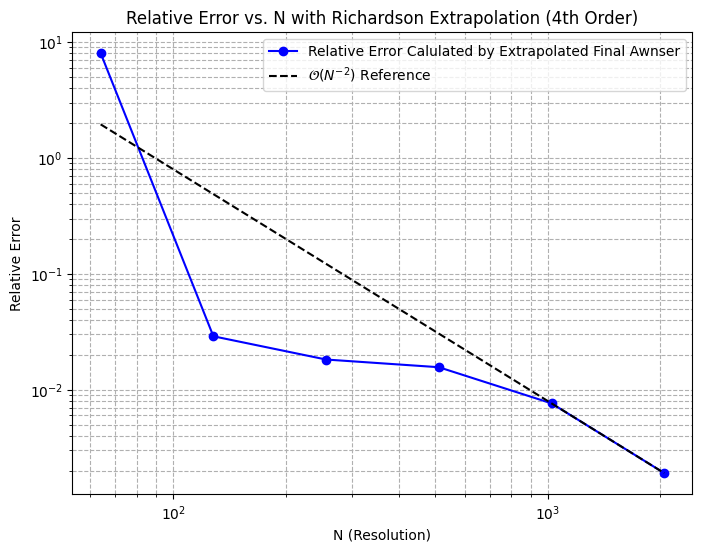

In [18]:
x_values = {
    64: results[0][1],    
    128: results[1][1],   
    256: results[2][1],   
    512: results[3][1],   
    1024: results[4][1], 
    2048: results[5][1] 
}

relative_errors = {}
for N, x_N in x_values.items():
    relative_errors[N] = abs(x_N - x_extrapolated) / abs(x_extrapolated)

plt.figure(figsize=(8, 6))
plt.loglog(list(relative_errors.keys()), list(relative_errors.values()), marker='o', linestyle='-', color='b', label='Relative Error Calulated by Extrapolated Final Awnser')

N_ref = np.array(list(relative_errors.keys()))
error_ref = relative_errors[N_ref[-1]] * (N_ref[-1] / N_ref)**2 
plt.loglog(N_ref, error_ref, 'k--', label=r"$\mathcal{O}(N^{-2})$ Reference")


plt.xlabel('N (Resolution)')
plt.ylabel('Relative Error')
plt.title('Relative Error vs. N with Richardson Extrapolation (4th Order)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()
